In [68]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

import os
import random
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

In [69]:
IMAGE_SIZE = [224, 224]
weight_size = 224
height_size = 224
batch_size = 32

In [70]:
train_path = './Dataset1/train/'
valid_path = './Dataset1/valid/'
test_path = './Dataset1/test/'

### Data Exploration

In [71]:
# Get a list of classes (groups) in your dataset
classes = [class_name for class_name in sorted(os.listdir(train_path)) if not class_name.startswith('.')]
print("Classes:", classes)

Classes: ['kick', 'punch']


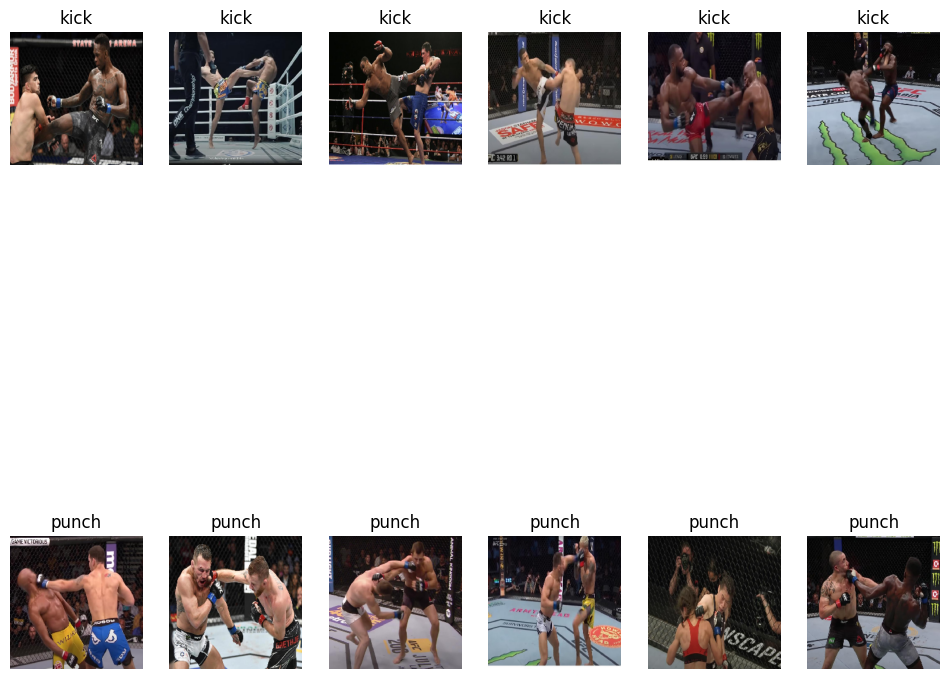

In [72]:
# Number of samples per class to display
num_samples_per_class = 6

# Function to display sample images from each class
def show_sample_images(data_dir, classes, num_samples_per_class):
    plt.figure(figsize=(12,12))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        class_images = random.sample(os.listdir(class_dir), num_samples_per_class)

        for j, image_name in enumerate(class_images):
            image_path = os.path.join(class_dir, image_name)
            image = load_img(image_path, target_size=(weight_size, height_size))

            plt.subplot(len(classes), num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')

    plt.show()

# Call the function to show sample images from each class
show_sample_images(train_path, classes, num_samples_per_class)


In [73]:
folders = glob('data/train/*')

In [74]:
len(folders)

0

In [75]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,           # Normalize pixel values to [0,1]
    rotation_range=90,           # Randomly rotate images by up to 20 degrees
    width_shift_range=0.4,       # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.4,      # Randomly shift images vertically by up to 20% of the height
    shear_range=0.5,             # Apply shear transformation
    zoom_range=0.2,              # Randomly zoom images by up to 20%
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Use the nearest pixel to fill missing areas after augmentation
)

In [76]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [77]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [78]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

Found 250 images belonging to 2 classes.


In [79]:
test_set = test_datagen.flow_from_directory(test_path,
                                             target_size=(224, 224),
                                             batch_size=batch_size,
                                             class_mode='categorical')

Found 32 images belonging to 2 classes.


In [80]:
valid_set = valid_datagen.flow_from_directory(valid_path,
                                             target_size=(224, 224),
                                             batch_size=batch_size,
                                             class_mode='categorical')

Found 85 images belonging to 2 classes.


### Displaying the augmentation of the images

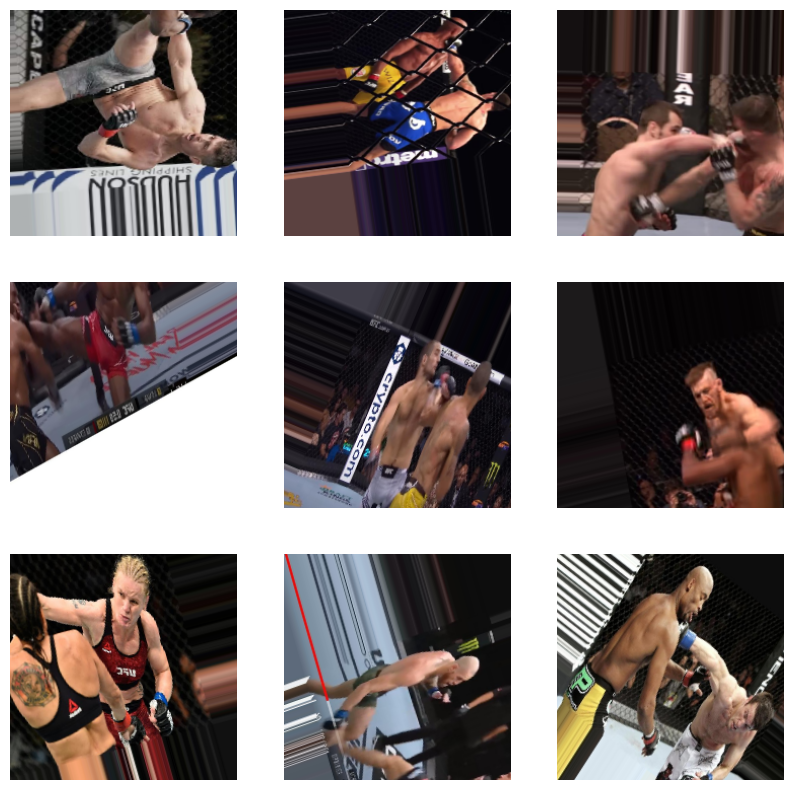

In [81]:
plt.figure(figsize=(10, 10))
images, _ = next(training_set)
for i, image in enumerate(images[: 9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')

### MobileNETV2

In [82]:
model = Sequential()
model.add(MobileNetV2(include_top = False, weights="imagenet", input_shape=(224,224,3)))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(1, activation = 'sigmoid'))
model.layers[0].trainable = False

In [83]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [84]:
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras import optimizers


model.compile(optimizer=RMSprop(lr=0.01), loss = 'binary_crossentropy', metrics = 'accuracy')

In [85]:
history = model.fit(training_set,
steps_per_epoch=8,
epochs=15,
verbose=1,
validation_data = valid_set,
validation_steps=8)

Epoch 1/15
8/8 [==============================] - ETA: 0s - loss: 0.8023 - accuracy: 0.5000WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 8 batches). You may need to use the repeat() function when building your dataset.


8/8 [==============================] - 7s 591ms/step - loss: 0.8023 - accuracy: 0.5000 - val_loss: 0.7560 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 2s 224ms/step - loss: 0.7581 - accuracy: 0.5000
Epoch 3/15
8/8 [==============================] - 2s 224ms/step - loss: 0.7609 - accuracy: 0.5000
Epoch 4/15
8/8 [==============================] - 2s 217ms/step - loss: 0.7513 - accuracy: 0.5000
Epoch 5/15
8/8 [==============================] - 2s 217ms/step - loss: 0.7582 - accuracy: 0.5000
Epoch 6/15
8/8 [==============================] - 2s 219ms/step - loss: 0.7505 - accuracy: 0.5000
Epoch 7/15
8/8 [==============================] - 2s 216ms/step - loss: 0.7444 - accuracy: 0.5000
Epoch 8/15
8/8 [==============================] - 2s 217ms/step - loss: 0.7543 - accuracy: 0.5000
Epoch 9/15
8/8 [==============================] - 2s 216ms/step - loss: 0.7382 - accuracy: 0.5000
Epoch 10/15
8/8 [==============================] - 2s 215ms/step - loss: 0.7296 - accur

In [86]:
model.evaluate(valid_set)

3/3 [==============================] - 0s 89ms/step - loss: 0.7460 - accuracy: 0.5000


[0.7460458874702454, 0.5]

In [87]:
STEP_SIZE_TEST=valid_set.n//valid_set.batch_size
valid_set.reset()
preds = model.predict(valid_set,
                      verbose=1)

3/3 [==============================] - 1s 153ms/step


In [88]:
fpr, tpr, _ = roc_curve(valid_set.classes, preds)

In [89]:
roc_auc = auc(fpr, tpr)

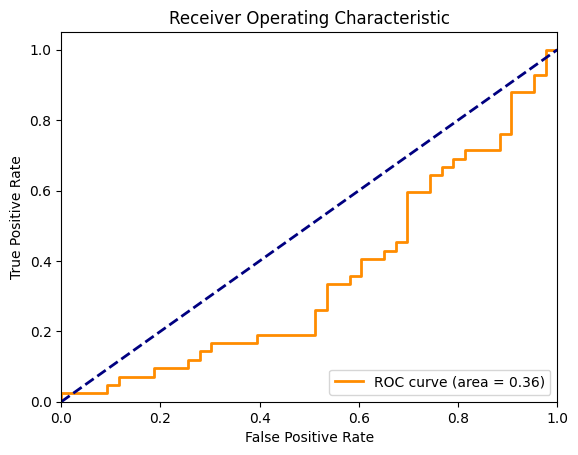

In [90]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()